# Reinforcement Learning for Trading


In this work we will learn strategy for trading using Q-Learning and compare it to benchmark and manual strategy.
We will first define some techincal indicators that we will use to create features and states for reinforecement learning. 
We will then learn the strategy with Q-Learning on the train set and test it later on the out of simple set

## Strategy
We limit the strategy actions in this work to long, short or close positions.
Long positions means buying or holding a n shares of a particular stock or asset.
Short positions means selling n or holding -n shares of a prticular stock or asset.
Closing positions means buying or selling the holdings to depending on the previous position.

### Technical indicators
In this section we will define the technical indicators we are using, the code definition of the used technical indicators can be found in src/technical_indicators.
#### Simple Moving Average
The simple Moving Average (SMA) smooths out price data by creating a constantly updated average. The average is taken over a specific period of time raging from minutes to weeks depending on the trader's forecast horizon or frequency.
The SMA helps reducing the noice in the price chart, giving a clearer look on the trend. 
#### SMA over Price Ratio
Various Strategies can be derived from the SMA. We define first the price over SMA ratio which is simply computed by dividing SMA of a Symbol by the Price its. 
If the ratio is above 1.05 then the stock is considered overbought and it could be a selling opportunity.
If the ratio is below 0.95 then the stock is considered oversold and it could be a buying opportunity.
Also, comparing the ratio of the symbol to the ratio of the index gives better estimation of best strategy to follow.
#### Relative Strenght Index
Usually if the ratio is high (higher than 70%), it's a bearish indicator and the assets in question are overbought and it is probably a selling opportunity as the prices will probably decrease afterwards.
If the ration is low (lower than 30%), it's a bullish indicator, the assets in question are oversold and it is probably a buying opportunity as the prices will probably increase afterwards.
#### Stochastic Oscillator
A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. The sensitivity of the oscillator to market movements is reducible by adjusting that time period or by taking a moving average of the result. It is used to generate overbought and oversold trading signals, utilizing a 0-100 bounded range of values.
Traditionally, readings over 80 are considered in the overbought range, and readings under 20 are considered oversold.
$$  \%K = (\frac{C-L_k}{H_k-L-k}) \times 100 $$
where:

$ L_k =$ the lowest price traded of the k pervious periods

$ H_k =$ the highest price traded during the same k previous periods

$ \%K =$ the current value of the stochastic indicator
#### Bollinger Bands
is a technical analysis tool defined by a set of lines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of the security's price, but can be adjusted to user preferences. 

#### BB Bandwidth
is a technical analysis indicator derived from the standard Bollinger Bands indicator. It can be used to identify trading signals in some instances.
$$Bollinger Bands Width = (Upper Band - Lower Band) / Middle Band$$

#### Momentum
Momentum is the measurement of the speed or velocity of price changes. Market momentum is measured by continually taking price differences for a fixed time interval. To construct a 10-day momentum line, simply subtract the closing price 10 days ago from the last closing price. This positive or negative value is then plotted around a zero line. 


In [8]:
# improting dependencies
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, 'src/') 
import data_reader
import technical_indicators as TI
import strategies
import function_helper as fh
import matplotlib.pyplot as plt

We first define the start and end date for the train and test periods, and the index we will use

In [3]:
index = 'JPM'
train_sd = '2008-01-01'
train_ed = '2015-12-31'
test_sd = '2016-01-01'
test_ed = '2018-12-31'
lookback = 25

We use the get_data function defined under src/data_reader to get both train and test sets 

In [4]:
train_data = data_reader.get_data(index = index, start_date=train_sd, end_date = train_ed )
test_data = data_reader.get_data(index = index, start_date=test_sd, end_date = test_ed )

We plot the adjusted price for the train and test period

Text(0.5,1,'Adjusted price of JPM on train and test periods')

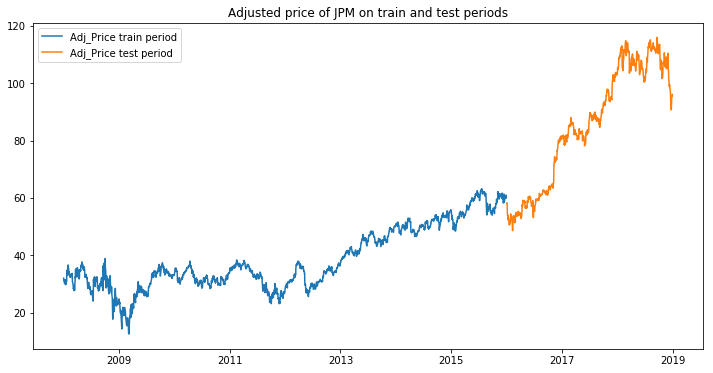

In [7]:
plt.figure(figsize=(12,6))
plt.plot(train_data["Adj Close"], label="Adj_Price train period")
plt.plot(test_data["Adj Close"], label="Adj_Price test period")
plt.legend()
plt.title("Adjusted price of "+index+" on train and test periods")

## Benchmark, Manual and Optimal Strategies
#### Benchmark Strategy
For the Benchmark strategy, we simply take a long position in the first trading day and keep it until the last day where we close that postion
#### Manual Strategy
For the Manual Strategy, we use a simple relative strength index strategy if it is higher than 70% we take a short position and if it is lower than 30% we take a long position
#### Optimal Strategy
In the Optimal Strategy, we chose the current position based on the nex period price (we take a peek into the future). The output strategy should be almost impossible to beat

In [15]:
# benchmark strategy
actions  = strategies.benchmark(train_data)
benchmark_portvals_in_sample = fh.compute_portvals(actions, train_data, order_value=100)
actions  = strategies.benchmark(test_data)
benchmark_portvals_out_of_sample = fh.compute_portvals(actions, test_data, order_value=100)
# Manual strategy
actions  = strategies.manual_strategy(train_data)
manual_portvals_in_sample = fh.compute_portvals(actions, train_data, order_value=100)
actions  = strategies.manual_strategy(test_data)
manual_portvals_out_of_sample = fh.compute_portvals(actions, test_data, order_value=100)
# Optimal strategy
actions = strategies.optimal_strategy(train_data)
optimal_portvals_in_sample = fh.compute_portvals(actions, train_data, order_value=100)
actions = strategies.optimal_strategy(test_data)
optimal_portvals_out_of_sample = fh.compute_portvals(actions, test_data, order_value=100)


## Reinforecement Learning
We train our Q-Learning model on the train or in sample period, we then test it on the test periods. We will first try training and testing on just one stock
#### Training 
For the training phase we will use Q Learning with 200 iterations with 200 dyna iterations. 
We define a state using a selection of technical indicators, and the current holding. The immidiate reward is the simply the daily return multipliyed by the holding
We update the Qtable with the following rule
$$ Q'[s,a] = (1 - \alpha) \times Q[s,a] + \alpha ( r + \gamma \times Q[s', argmax_{a'}(Q[s',a'])]) $$
Where:
$s$ is the current state, $a$ is the action, $s'$ is the new state, $r$ is the immidate reward for taking action $a$ in state $s$, $argmax_{a'}(Q[s',a'])$ is the action that maximizes the Q-value among all possible actions $a'$ from $s'$, and $\alpha \in [0,1]$ is the learning rate used   


In [10]:
# RL strategy
learner = strategies.StrategyLearner()
print learner.addEvidence(train_data,200)
actions =learner.testPolicy(train_data)
Q_portvals_in_sample = fh.compute_portvals(actions, train_data, order_value=100)
actions =learner.testPolicy(test_data)
Q_portvals_out_of_sample = fh.compute_portvals(actions, test_data, order_value=100)

iteration 
0
iteration 
1
iteration 
2
iteration 
3
iteration 
4
iteration 
5
iteration 
6
iteration 
7
iteration 
8
iteration 
9
iteration 
10
iteration 
11
iteration 
12
iteration 
13
iteration 
14
iteration 
15
iteration 
16
iteration 
17
iteration 
18
iteration 
19
iteration 
20
iteration 
21
iteration 
22
iteration 
23
iteration 
24
iteration 
25
iteration 
26
iteration 
27
iteration 
28
iteration 
29
iteration 
30
iteration 
31
iteration 
32
iteration 
33
iteration 
34
iteration 
35
iteration 
36
iteration 
37
iteration 
38
iteration 
39
iteration 
40
iteration 
41
iteration 
42
iteration 
43
iteration 
44
iteration 
45
iteration 
46
iteration 
47
iteration 
48
iteration 
49
iteration 
50
iteration 
51
iteration 
52
iteration 
53
iteration 
54
iteration 
55
iteration 
56
iteration 
57
iteration 
58
iteration 
59
iteration 
60
iteration 
61
iteration 
62
iteration 
63
iteration 
64
iteration 
65
iteration 
66
iteration 
67
iteration 
68
iteration 
69
iteration 
70
iteration 
71
it

We plot the normalized values of the strategy in sample and out of sample with a start value of a 1000$

Text(0.5,1,'Qlearning strategy vs manual_strategy and benchmark insample')

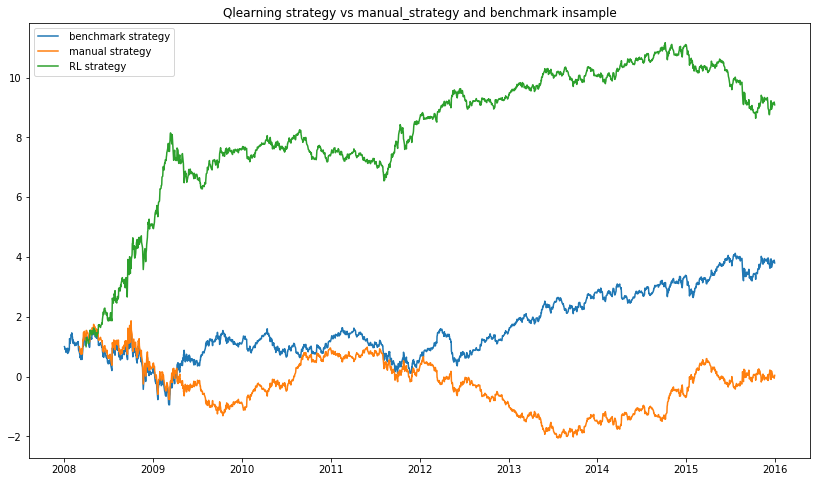

In [19]:
# plotting the resutls
plt.figure(figsize=(14,8))
plt.plot(benchmark_portvals_in_sample/benchmark_portvals_in_sample.iloc[0], label=" benchmark strategy")
plt.plot(manual_portvals_in_sample/manual_portvals_in_sample.iloc[0], label=" manual strategy")
#plt.plot(optimal_portvals_in_sample, label=" optimal strategy")
plt.plot(Q_portvals_in_sample/Q_portvals_in_sample.iloc[0], label=" RL strategy")
plt.legend()
plt.title("Qlearning strategy vs manual_strategy and benchmark insample")

Text(0.5,1,'Qlearning strategy vs manual_strategy and benchmark insample')

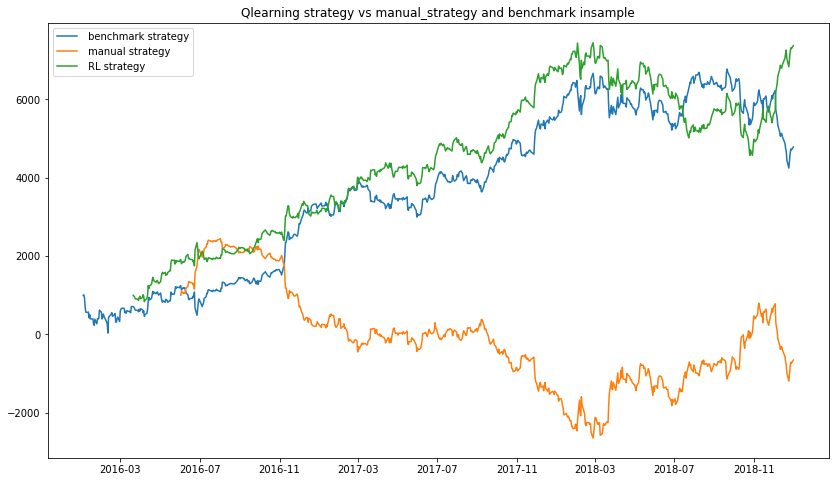

In [17]:
plt.figure(figsize=(14,8))
plt.plot(benchmark_portvals_out_of_sample/benchmark_portvals_out_of_sample.iloc[0], label=" benchmark strategy")
plt.plot(manual_portvals_out_of_sample, label=" manual strategy")
#plt.plot(Q_portvals_out_of_sample, label=" optimal strategy")
plt.plot(Q_portvals_out_of_sample, label=" RL strategy")
plt.legend()
plt.title("Qlearning strategy vs manual_strategy and benchmark insample")